# ML Final Project - MSDS University of Chicago
## TEAM : 12
1. Rishab Mohan
2. Hasan
3. Yujata

In [ ]:
print("\nAbout Signature Verification Dataset:")
print("Soure - https://www.kaggle.com/code/rahulkumarpatro/signature-classification-using-siamese/input")
print("This dataset contains signatures of Dutch users categorized into genuine and fraudulent signatures.")
print("The directory number represents the name of the user, and it's classified into two categories:")
print("- Genuine: Signatures with the user's own number")
print("- Fraudulent: Signatures with the user's number followed by '_forg'")


### Import Necessary Packages

In [3]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import os
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
from PIL import Image
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

## 0. Load Signature Verification Dataset

In [5]:

train_csv = "/content/train_data.csv"
test_csv = "/content/test_data.csv"
#train_dir = "/content/drive/MyDrive/train"
#test_dir = "/content/drive/MyDrive/test"


## 1. Data Exploration

In [6]:
df_train=pd.read_csv(train_csv)
df_train.sample(10)

,068/09_068.png,068_forg/03_0113068.PNG,1
23068,031/02_031.png,031_forg/03_0121031.PNG,1
19642,027/05_027.png,027/07_027.png,0
10546,048/06_048.png,048_forg/01_0204048.PNG,1
1014,047/02_047.png,047/06_047.png,0
14769,016/016_06.PNG,016/016_11.PNG,0
20395,056/01_056.png,056_forg/04_0105056.PNG,1
11306,003/003_03.PNG,003/003_22.PNG,0
14277,069/04_069.png,069/12_069.png,0
7979,009/009_19.PNG,009/009_24.PNG,0
7076,024/09_024.png,024/03_024.png,0


In [7]:
df_test=pd.read_csv(test_csv)
df_test.sample(10)

,068/09_068.png,068_forg/03_0113068.PNG,1
5380,061/04_061.png,061/08_061.png,0
1457,051/08_051.png,051/03_051.png,0
3823,054/09_054.png,054_forg/03_0208054.PNG,1
4826,059/09_059.png,059/06_059.png,0
1745,050/06_050.png,050/09_050.png,0
1645,050/10_050.png,050_forg/01_0125050.PNG,1
3374,060/03_060.png,060/08_060.png,0
102,068/09_068.png,068/05_068.png,0
3253,060/01_060.png,060_forg/03_0121060.PNG,1
4163,054/04_054.png,054/12_054.png,0


In [8]:
df_train.shape


(23205, 3)

In [9]:
df_test.shape


(5747, 3)

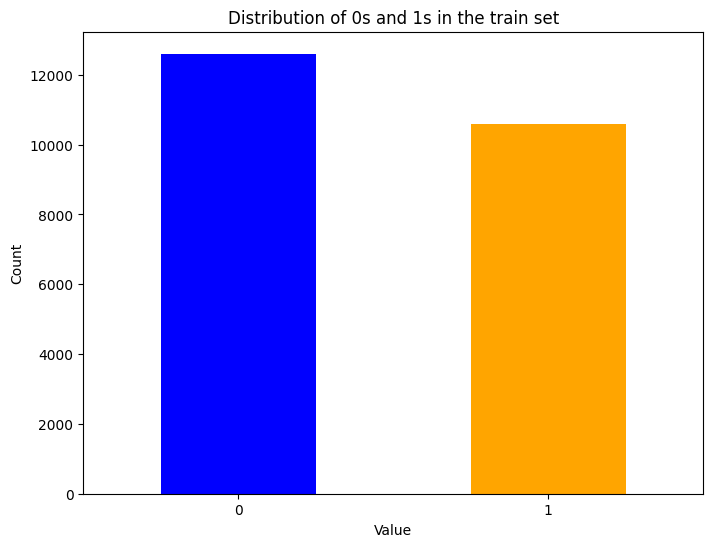

In [15]:
# train 0,1 distribution
target_column = df_train.iloc[:, 2]

value_counts = target_column.value_counts()

plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of 0s and 1s in the train set')
plt.xlabel('Value')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

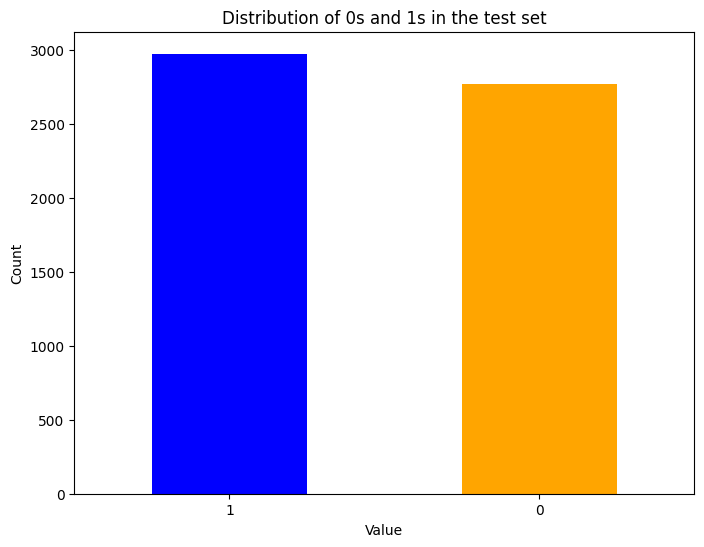

In [14]:
# test 0,1 distribution
target_column = df_test.iloc[:, 2]

value_counts = target_column.value_counts()

plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of 0s and 1s in the test set')
plt.xlabel('Value')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Building Siamese Model

In [ ]:
df_train[4:5]

,068/09_068.png,068_forg/03_0113068.PNG,1
4,068/09_068.png,068_forg/04_0113068.PNG,1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image1_path=os.path.join(train_dir,df_train.iat[4,0])
image1_path

'/content/drive/MyDrive/train/068/09_068.png'

## 2. Making Custom Pytorch Siamese Dataset
Returns Image1, Image2 and the class label(whether 0 or 1).

In [ ]:

class CustomDataset(Dataset):
    def __init__(self, train_dir=None, train_csv=None, transform=None):
        self.train_dir = train_dir
        self.train_data = pd.read_csv(train_csv)
        self.train_data.columns = ['image1', 'image2', 'class']
        self.transform = transform

    def __getitem__(self, idx):
        img1_name = self.train_data.iloc[idx, 0]
        img2_name = self.train_data.iloc[idx, 1]
        label = int(self.train_data.iloc[idx, 2])

        img1_path = os.path.join(self.train_dir, img1_name)
        img2_path = os.path.join(self.train_dir, img2_name)

        img1 = Image.open(img1_path).convert('L')
        img2 = Image.open(img2_path).convert('L')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        label_tensor = torch.tensor([label], dtype=torch.float32)

        return img1, img2, label_tensor

    def __len__(self):
        return self.train_data.shape[0]


In [ ]:
dataset = CustomDataset(train_dir,train_csv,transform=transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()]))

In [ ]:
dataset

## 3. Build Siamese Neural Network

In [ ]:
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.conv_layer1 = nn.Conv2d(1, 50, kernel_size=5)
        self.pool_layer1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Layer 1: Input (1, 28, 28) -> Convolution (50, 24, 24) -> Pooling (50, 12, 12)

        self.conv_layer2 = nn.Conv2d(50, 60, kernel_size=5)
        self.pool_layer2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Layer 2: Input (50, 12, 12) -> Convolution (60, 8, 8) -> Pooling (60, 4, 4)

        self.conv_layer3 = nn.Conv2d(60, 80, kernel_size=3)
        # Layer 3: Input (60, 4, 4) -> Convolution (80, 2, 2)

        self.batch_norm_layer1 = nn.BatchNorm2d(50)
        self.batch_norm_layer2 = nn.BatchNorm2d(60)

        # Fully Connected Layers
        self.fc_layer1 = nn.Linear(32000, 128)
        self.fc_layer2 = nn.Linear(128, 2)

    def feature_extractor(self, x):
        x = self.conv_layer1(x)
        x = self.batch_norm_layer1(x)
        x = F.relu(x)
        x = self.pool_layer1(x)

        x = self.conv_layer2(x)
        x = self.batch_norm_layer2(x)
        x = F.relu(x)
        x = self.pool_layer2(x)

        x = self.conv_layer3(x)
        x = F.relu(x)

        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc_layer1(x))
        x = self.fc_layer2(x)

        return x

    def forward(self, input1, input2):
        output1 = self.feature_extractor(input1)
        output2 = self.feature_extractor(input2)

        return output1, output2

## 4.  Constrastive Loss Function

In [ ]:
class CustomContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=1.5):
        super(CustomContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 3) +  # Changed power to 3
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.5), 2))  # Adjusted clamp value

        return loss_contrastive

In [ ]:
train_dataloader = DataLoader(dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=32)

In [ ]:
train_dataloader


In [ ]:
if torch.cuda.is_available():
    print('Yes')

Yes


In [ ]:
net = SiameseNetwork().cuda()

criterion = CustomContrastiveLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 3e-4)

optimizer = optim.RMSprop(net.parameters(), lr=1e-4, alpha=0.99)

In [ ]:
def train():
    loss= []

    for epoch in range(1,10):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()

        print("Epoch {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))

        loss.append(loss_contrastive.item())

    return net

In [ ]:
model = train()
torch.save(model.state_dict(), "model.pt")
print("Model Saved Successfully")

Epoch 1
 Current loss 0.3414917588233948

Epoch 2
 Current loss 0.6100888848304749

Epoch 3
 Current loss 0.7994491457939148

Epoch 4
 Current loss 0.49114492535591125

Epoch 5
 Current loss 0.33568525314331055

Epoch 6
 Current loss 0.5720422863960266

Epoch 7
 Current loss 0.7909325361251831

Epoch 8
 Current loss 0.6773213148117065

Epoch 9
 Current loss 0.603416383266449

Model Saved Successfully


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load("model.pt"))

<All keys matched successfully>

In [ ]:
test_dataset = CustomDataset(test_dir,test_csv,transform=transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()]))

test_dataloader = DataLoader(test_dataset,num_workers=8,batch_size=1,shuffle=True)

In [ ]:
test_dataloader

In [ ]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## 5.  Model Evalaution
Testing the model by comparing the model's distance prediction between two pairs of Signature

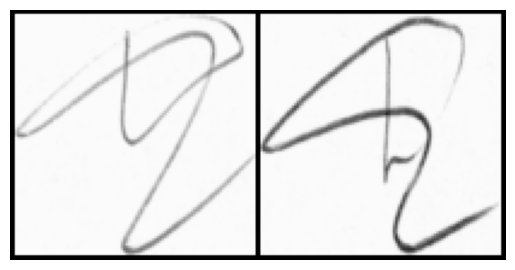

Predicted Eucledian Distance:- 0.6916766166687012
Actual Label:- Forged Pair Of Signature


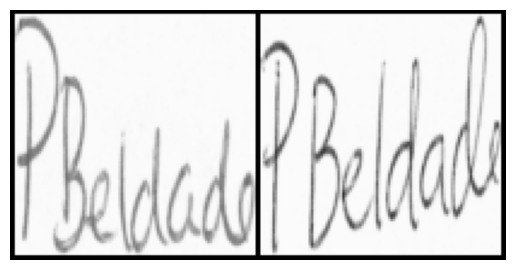

Predicted Eucledian Distance:- 0.741412341594696
Actual Label:- Forged Pair Of Signature


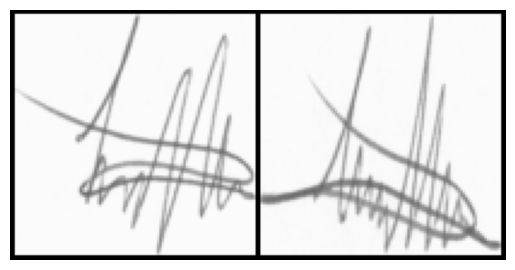

Predicted Eucledian Distance:- 0.18102715909481049
Actual Label:- Original Pair Of Signature


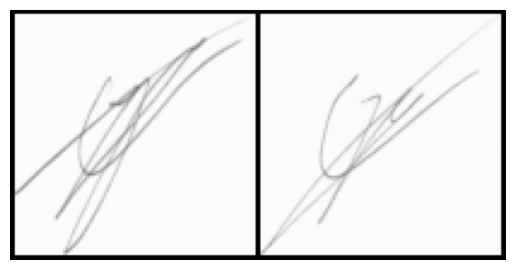

Predicted Eucledian Distance:- 0.48568204045295715
Actual Label:- Original Pair Of Signature


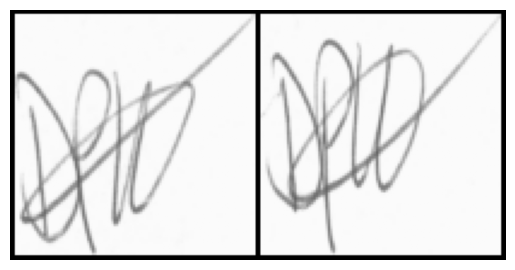

Predicted Eucledian Distance:- 0.26664090156555176
Actual Label:- Original Pair Of Signature


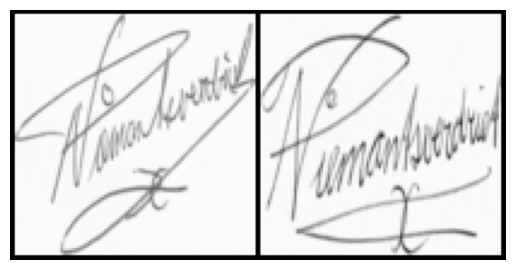

Predicted Eucledian Distance:- 0.5343760848045349
Actual Label:- Forged Pair Of Signature


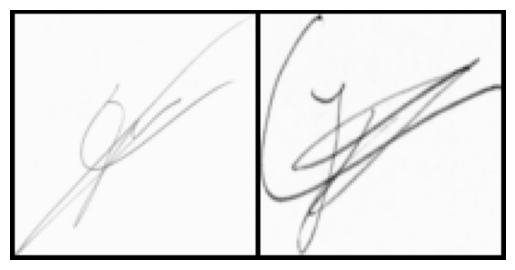

Predicted Eucledian Distance:- 0.5463297367095947
Actual Label:- Forged Pair Of Signature


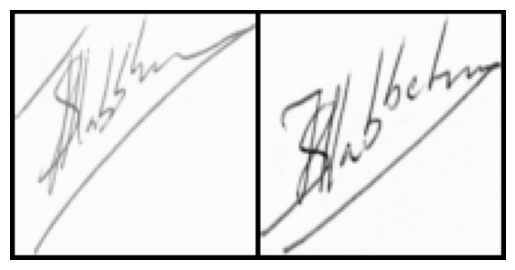

Predicted Eucledian Distance:- 0.3254932165145874
Actual Label:- Forged Pair Of Signature


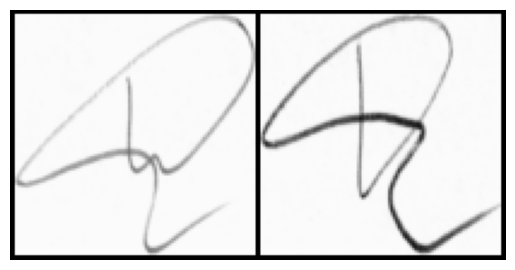

Predicted Eucledian Distance:- 0.821236789226532
Actual Label:- Forged Pair Of Signature


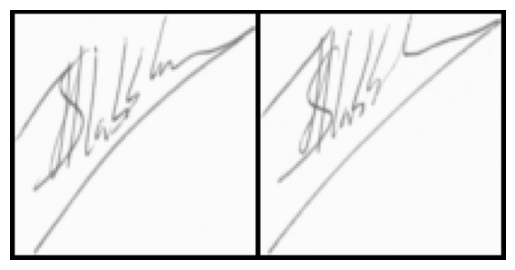

Predicted Eucledian Distance:- 0.5406924486160278
Actual Label:- Original Pair Of Signature


In [ ]:
count=0
for i, data in enumerate(test_dataloader,0):
  x0, x1 , label = data
  concat = torch.cat((x0,x1),0)
  output1,output2 = model(x0.to(device),x1.to(device))

  eucledian_distance = F.pairwise_distance(output1, output2)

  if label==torch.FloatTensor([[0]]):
    label="Original Pair Of Signature"
  else:
    label="Forged Pair Of Signature"

  imshow(torchvision.utils.make_grid(concat))
  print("Predicted Eucledian Distance:-",eucledian_distance.item())
  print("Actual Label:-",label)
  count=count+1
  if count ==10:
     break


Accuracy: 39.41%


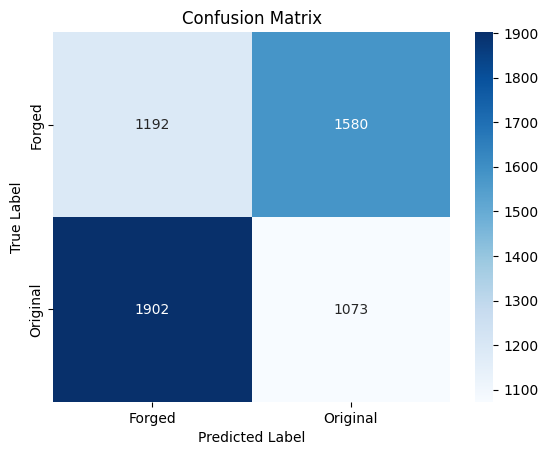

Classification Report:
              precision    recall  f1-score   support

         0.0       0.39      0.43      0.41      2772
         1.0       0.40      0.36      0.38      2975

    accuracy                           0.39      5747
   macro avg       0.39      0.40      0.39      5747
weighted avg       0.40      0.39      0.39      5747



In [ ]:
# Function to evaluate the model
def evaluate_model(test_dataloader, model):
    y_true = []
    y_pred = []

    for i, data in enumerate(test_dataloader, 0):
        x0, x1, label = data
        output1, output2 = model(x0.to(device), x1.to(device))

        eucledian_distance = F.pairwise_distance(output1, output2)

        # Classify as similar if distance is less than a threshold
        similarity_threshold = 0.5  # Adjust as needed
        prediction = 1 if eucledian_distance.item() < similarity_threshold else 0

        y_true.append(label.item())
        y_pred.append(prediction)

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy: {:.2f}%".format(accuracy * 100))

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Forged', 'Original'], yticklabels=['Forged', 'Original'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

# Evaluate the model
evaluate_model(test_dataloader, model)
